In [24]:
import cv2
import numpy as np 
import torch 
from torchvision import transforms, models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision


In [133]:
from scipy.spatial import distance


In [25]:
resnet_model = models.resnet50(pretrained = True)

/Users/niteeqsheik/anaconda3/envs/WebDB_Project/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niteeqsheik/anaconda3/envs/WebDB_Project/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
from torchvision import transforms

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [28]:
from sklearn.cluster import KMeans

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
print(cv2.__version__)

4.6.0


In [31]:
dataset = torchvision.datasets.Caltech101('/Users/niteeqsheik/Desktop/CSE515-Project(Git)',download=True)
data_loader = torch.utils.data.DataLoader(dataset,
batch_size=4,
shuffle=True,
num_workers=8)
print(len(dataset))

Files already downloaded and verified
8677


In [32]:
print(len(dataset))

8677


In [33]:
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

This is ID:8000
label:92


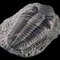

In [34]:
image_ID =8000
img, label = dataset[image_ID]
print(f'This is ID:{image_ID}')
print(f'label:{label}')
newsize = (60, 60)
img = img.resize(newsize)
display(img)

In [35]:
labels_caltech_101 = np.array([dataset[i][1] for i in range(len(dataset))])

In [36]:
print(len(labels_caltech_101))

8677


In [37]:
from PIL import Image
from torchvision import datasets
import torch
import numpy as np
from scipy.stats import skew
import csv
from tqdm import tqdm

# Initialize an empty list to store color moments
color_moments_list = []

# Initialize an empty list to store img_arrays (if needed)
all_img_arrays = []

# Loop through the dataset
for image_ID in tqdm(range(len(dataset))):
    img, label = dataset[image_ID]
    
    # Step 1: Resize the image to 300x100
    new_size = (300, 100)
    img_resized = img.resize(new_size)
    
    # Convert the PIL Image to a NumPy array
    img_array = np.array(img_resized)
    
    #grayscale image check 
    is_gray = len(img_array.shape) == 2
    
    # Append the img_array to the list (if you need to keep all arrays)
    all_img_arrays.append(img_array)

    # Step 2: Partition the image into a 10x10 grid
    for i in range(0, 300, 30):
        for j in range(0, 100, 10):
            grid_cell = img_array[j:j+10, i:i+30]
            
            # Step 3: Calculate the color moments for each grid cell
            color_moments_dict = {}
            for color_channel, color_name in enumerate(['Gray'] if is_gray else ['Red', 'Green', 'Blue']):
                channel_data = grid_cell if is_gray else grid_cell[:, :, color_channel]

                # Calculate mean, standard deviation, and skewness
                channel_mean = np.mean(channel_data)
                channel_std = np.std(channel_data)
                if np.all(channel_data == channel_data[0]):
                    channel_skewness = 0
                else :
                    channel_skewness = skew(channel_data.reshape(-1))
                
                # Store the color moments in the dictionary
                color_moments_dict[f"{color_name}_Mean"] = channel_mean
                color_moments_dict[f"{color_name}_Std"] = channel_std
                color_moments_dict[f"{color_name}_Skewness"] = channel_skewness
            
            # Include the ImageID
            color_moments_dict["ImageID"] = image_ID
            
            # Append the color moments to the list
            color_moments_list.append(color_moments_dict)

  0%|          | 0/8677 [00:00<?, ?it/s]

100%|██████████| 8677/8677 [05:59<00:00, 24.13it/s]


#### Use hog_features_dict as the feature matrix

In [38]:
from torchvision import datasets
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import numpy as np
from tqdm import tqdm

# Assuming you've already loaded the dataset like this:
# dataset = datasets.Caltech101('/path/to/dataset', download=True)

def extract_hog_features(image):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    
    # Check if the image is grayscale
    if len(image_np.shape) == 2:
        gray_image = image_np
    else:
        gray_image = rgb2gray(image_np)
    
    # Resize the image
    resized_image = resize(gray_image, (300, 100))
    
    # Compute the HOG features
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(30, 10),
                              cells_per_block=(1, 1), visualize=True)
    
    return features, hog_image

# Initialize empty dictionaries to store features and labels
hog_features_dict = {}
hog_images_dict = {}
labels_dict = {}

# Loop over the dataset with progress bar
for i in tqdm(range(len(dataset)), desc="Extracting HOG features"):
    image, label = dataset[i]
    features, hog_image = extract_hog_features(image)
    hog_features_dict[i] = features
    hog_images_dict[i] = hog_image
    labels_dict[i] = label

# Now:
# hog_features_dict contains the 900-dimensional feature descriptor for each image, indexed by dataset index
# hog_images_dict contains the visual representation of the HOG features for each image, indexed by dataset index
# labels_dict contains the label for each image, indexed by dataset index


Extracting HOG features: 100%|██████████| 8677/8677 [00:57<00:00, 150.19it/s]


In [39]:
print(hog_features_dict[0].shape)

(900,)


In [41]:
import pandas as pd
hog_features_df = pd.DataFrame.from_dict(hog_features_dict, orient="index")

hog_features_df["ImageID"] = hog_features_df.index

csv_file_name = "hog_features.csv"
hog_features_df.to_csv(csv_file_name,index=False)
print("Done!")

Done!


In [42]:
print(len(color_moments_list))

867700


In [43]:
# Resnet computations 
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.53994344, 0.52009986, 0.49254049], 
                         [0.31415099, 0.30712622, 0.31878401]),  # Normalize the images
])

def resnet_computations(hook_layer, dataset):
    
    # List to store the output tensors for each image along with their ImageID
    outputs_with_ids = []
    skipped_images = []
    
    # List to temporarily capture the output tensor from the hook
    captured_output = [None]

    # Hook function to capture the output tensor of a specified layer
    def capture_output(module, input, output):
        captured_output[0] = output

    # Register the hook function to the specified layer
    if hook_layer == 'avgpool':
        hook = resnet_model.avgpool.register_forward_hook(capture_output)
    elif hook_layer == 'layer3':
        hook = resnet_model.layer3.register_forward_hook(capture_output)
    elif hook_layer == 'fc':   
        hook = resnet_model.fc.register_forward_hook(capture_output)

    # Loop through the dataset
    for i in tqdm(range(len(dataset))):
        try:
            img, label = dataset[i]
            #skipping grayscale images 
            if img.mode == 'L' or img.mode == '1':
                img = img.convert("RGB")

            # Apply transformations and prepare image batch
            img_tensor = transform(img)
            img_batch = img_tensor.unsqueeze(0)  # Add a batch dimension

            # Forward pass (disable gradient computation to save memory)
            with torch.no_grad():
                resnet_model(img_batch)
            
            # Retrieve the captured output tensor
            resnet_output = captured_output[0]
            if resnet_output is None:
                print("Warning: Hook Not Triggered")
                skipped_images.append(i)
                continue

            # Process the output tensor depending on the specified layer and store it in a dictionary
            output_dict = {"ImageID": i}
            if hook_layer == 'avgpool':
                avgpool_output = resnet_output.flatten().cpu().numpy()
                averaged_values = [(avgpool_output[i] + avgpool_output[i+1]) / 2.0 for i in range(0, len(avgpool_output), 2)]
                output_dict["Output"] = np.array(averaged_values)
            elif hook_layer == 'layer3':
                avg_vector = resnet_output.mean(dim=[2, 3]).cpu().numpy().squeeze()
                output_dict["Output"] = avg_vector
            elif hook_layer == 'fc':
                output_dict["Output"] = resnet_output.cpu().numpy().squeeze()
            
            # Append the dictionary to the list
            outputs_with_ids.append(output_dict)
        except Exception as e:
            print(f"Error processing ImageID {i}: {e}")
            skipped_images.append(i)
    # Remove the hook to free resources
    hook.remove()
    
    return outputs_with_ids

In [44]:
output_avgpool_with_ids = resnet_computations('avgpool',dataset)

100%|██████████| 8677/8677 [05:45<00:00, 25.15it/s]


In [45]:
print(len(output_avgpool_with_ids))

8677


In [46]:
output_layers3_with_ids = resnet_computations('layer3',dataset)

100%|██████████| 8677/8677 [06:56<00:00, 20.81it/s]


In [47]:
print(len(output_layers3_with_ids))

8677


In [48]:
output_fc_with_ids = resnet_computations('fc',dataset)

100%|██████████| 8677/8677 [06:58<00:00, 20.73it/s]


In [49]:
print(len(output_fc_with_ids))

8677


In [50]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

In [51]:
from tqdm import tqdm

In [52]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")

In [53]:
# print(len(df_color_moments))

In [54]:
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values

In [55]:
# print(feature_columns)

In [56]:
# print(data_color_moments[0]) 

In [57]:
from sklearn.decomposition import TruncatedSVD

In [58]:
# k = 5 
# svd = TruncatedSVD(n_components = k)
# latent_semantics = svd.fit_transform(data_color_moments)
# print("Reduced Data:(Latent Semantics)")
# print(latent_semantics)

In [101]:
def SVD_calc(feature_matrix,k):
    #print("Enter SVD calc")
    svd = TruncatedSVD(n_components=k)
    latent_semantics = svd.fit_transform(feature_matrix)
    #print("The latent semantics are:")
    return latent_semantics

In [60]:
from sklearn.decomposition import NMF 

In [61]:
def NMF_calculator(feature_matrix,k):
    nmf = NMF(n_components=k)
    W = nmf.fit_transform(feature_matrix)
    H = nmf.components_
    return H 

In [125]:
def LDA_calculator(feature_matrix,k):
    lda = LinearDiscriminantAnalysis(n_components = k)
    lda_result = lda.fit_transform(feature_matrix,labels_caltech_101)
    top_k_latent = lda.scalings_[:, :k]
    return lda_result
    

In [132]:
def k_means_calculator(feature_matrix,k):
    kmeans = KMeans(n_clusters = k,random_state=0)
    kmeans.fit(feature_matrix)
    top_k_latent_semantics = kmeans.cluster_centers_
    return top_k_latent_semantics

## Below Is the Code Of Block of converting the Phase 1 results into feature matrices

In [64]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values
# print(feature_columns)
# print(data_color_moments[0]) 

#### In the Below code block use data_color_moments as the feature matrix for SVD 
#### Use the X_color_moments for NMF and X_standardized_color_moments for remaining

In [65]:

import pandas as pd 
color_moments_df = pd.DataFrame(color_moments_list)
color_moments_df.fillna(color_moments_df.mean(), inplace=True)
data_color_moments= color_moments_df.drop(columns="ImageID").to_numpy()
n_grids_per_image = 10 * 10  # 10x10 grid for each image
n_features_per_grid = data_color_moments.shape[1]
X_color_moments = data_color_moments.reshape(len(dataset), n_grids_per_image * n_features_per_grid)


In [66]:
# csv_file_name = "color_moments.csv"
# color_moments_df.to_csv(csv_file_name,index=False)
# print("Color Moment DataFrame saved to", csv_file_name)

In [67]:
scaler_2 = StandardScaler()
X_standardized_color_moments = scaler_2.fit_transform(X_color_moments)

In [124]:
print(len(X_standardized_color_moments))

8677


In [69]:
print(len(X_color_moments))

8677


#### Use X_hog for nmf and X_hog_standardized for remaining

In [70]:

X_hog = np.array(list(hog_features_dict.values()))
scaler = StandardScaler()
X_hog_standardized = scaler.fit_transform(X_hog)


In [71]:
#print(X_hog_standardized[0])

#### Feature Matrix Conversion of Resnet computations

In [72]:
X_resnet_avgpool = np.array([entry["Output"] for entry in output_avgpool_with_ids])
X_resnet_layers3 = np.array([entry["Output"] for entry in output_layers3_with_ids])
X_resnet_fc = np.array([entry["Output"] for entry in output_fc_with_ids])


In [73]:
print(len(X_resnet_layers3))

8677


#### Use X_resnet_{layer_value} for NMF and X_standardized_resnet_{layer_value} for remaining reduction technique

In [74]:
#Standardizing the data 
scaler_1 = StandardScaler()
X_standardized_resnet_avgpool = scaler_1.fit_transform(X_resnet_avgpool)
X_standardized_resnet_layers3 = scaler_1.fit_transform(X_resnet_layers3)
X_standardized_resnet_fc = scaler_1.fit_transform(X_resnet_fc)

In [75]:
print(len(X_standardized_resnet_fc))

8677


In [76]:
#print(X_standardized_resnet_fc[0])

##  Create the UI here and call appropriate functions


In [77]:
def get_feature_model_data(feature_model):
    if feature_model == "Color Moments":
        X_data = X_color_moments
        X_standardized = X_standardized_color_moments
    elif feature_model == "HOG Descriptor":
        X_data = X_hog
        X_standardized = X_hog_standardized
    elif  feature_model == "Resnet FC":
        X_data = X_resnet_fc
        X_standardized = X_standardized_resnet_fc
    elif feature_model == "Resnet Avgpool":
        X_data = X_resnet_avgpool
        X_standardized= X_standardized_resnet_avgpool 
    elif feature_model == "Resnet Layer 3":
        X_data = X_resnet_layers3
        X_standardized= X_standardized_resnet_layers3
    else:
        return -1
    return X_data,X_standardized
        

In [78]:
def dimensionality_reduction(X_data,X_standardized,technique,k):
    if technique == 'SVD':
        #print("Entered SVD")
        result = SVD_calc(X_standardized,k)
    elif technique == 'NNMF':
        result = NMF_calculator(X_data,k)
    elif technique =='LDA':
        result = LDA_calculator(X_standardized,k)
    elif technique == 'k-means':
        result = k_means_calculator(X_standardized,k)
    else :
        return -1
    return result

In [104]:
def savetocsv(result,feature_model,k,technique_choice):
    df = pd.DataFrame(result)
    df.columns = [f'LatentSemantic{i+1}' for i in range(df.shape[1])]

    df['ImageID'] = range(len(df))

    #Save file to CSV 
    filename = f"{feature_model}_k{k}_{technique_choice}.csv"
    df.to_csv(filename, index=False)
    print("Output saved to", filename)
    #For each latent semantic order imageIDs by their weights 
    for i in range(min(df.shape[1],k)):
        sorted_df = df[['ImageID', f'LatentSemantic{i+1}']].sort_values(by=f'LatentSemantic{i+1}', ascending=False)
        print(f"Top images for LatentSemantic{i+1}")
        print(sorted_df.head())

In [135]:
def process_kmeans_result(result, feature_matrix):    
    # Compute distance of each image's features to each of the cluster centers
    distances_to_clusters = distance.cdist(feature_matrix, result, 'euclidean')

    imageID_weight_pairs = {}
    for cluster_idx in range(result.shape[0]):
        distances_for_cluster = distances_to_clusters[:, cluster_idx]
        
        # Pairing imageIDs with their distances and sorting by distance
        paired_sorted = sorted(enumerate(distances_for_cluster), key=lambda x: x[1])
        
        # Only storing the imageID for simplicity
        imageID_weight_pairs[f'Cluster_{cluster_idx}'] = [item[0] for item in paired_sorted]
    
    # Printing the results
    for cluster, imageIDs in imageID_weight_pairs.items():
        print(f"{cluster}: {imageIDs}")
        
    return imageID_weight_pairs


In [138]:
def main():
    #Select a Feature Model
    # Prompt user for feature model
    print("Choose a feature model:")
    print("1. Color Moments")
    print("2. HOG Descriptor")
    print("4. Resnet Avgpool")
    print("3. Resnet FC")
    print("5. Resnet Layer 3")
    feature_model_choice = input("Enter your choice(number): ")
    # Convert choice to string name
    feature_model = ["Color Moments", "HOG Descriptor", "Resnet FC", "Resnet Avgpool", "Resnet Layer 3"][int(feature_model_choice) - 1]
    print("Feature Model Selected:",feature_model)
    #print(feature_model)
    X_data, X_standardized_data = get_feature_model_data(feature_model)
    print("Length of input data standardized",len(X_standardized_data))
    print("Length of input data ",len(X_data))
#Select the Dimensionality Reduction Technique 
    k = int(input('Please Enter the value of k'))
    print("Value of k",k)
    # Prompt user for dimensionality reduction technique
    print("\nChoose a dimensionality reduction technique:")
    print("1. SVD")
    print("2. NNMF")
    print("3. LDA")
    print("4. k-means")
    technique_choice = input("Enter your choice: ")
    #Convert choice to specified string 
    technique = ["SVD", "NNMF", "LDA", "k-means"][int(technique_choice) - 1]
    result = dimensionality_reduction(X_data,X_standardized_data,technique,k,)
    print("Technique Choice Selected", technique)
    if technique == "k-means":
        imageID_weight_pairs = process_kmeans_result(result,X_standardized_data)
        # savetocsv(result,feature_model,k,technique)
    else:            
        # savetocsv(result,feature_model,k,technique)
        df = pd.DataFrame(result)
        print("The shape is",df.shape[1])
        print("The length is",len(df))



In [140]:
main()

Choose a feature model:
1. Color Moments
2. HOG Descriptor
4. Resnet Avgpool
3. Resnet FC
5. Resnet Layer 3
Feature Model Selected: Resnet Avgpool
Length of input data standardized 8677
Length of input data  8677
Value of k 10

Choose a dimensionality reduction technique:
1. SVD
2. NNMF
3. LDA
4. k-means


/Users/niteeqsheik/anaconda3/envs/WebDB_Project/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Technique Choice Selected k-means
Cluster_0: [4453, 2074, 4049, 2481, 7517, 3456, 4412, 6088, 2146, 7010, 4530, 2118, 3405, 5230, 7206, 2862, 7062, 3343, 5439, 3726, 3517, 2982, 3250, 4651, 6126, 2339, 5256, 5254, 1148, 7537, 7781, 2317, 7262, 3479, 7192, 3476, 3377, 3496, 2968, 3730, 2746, 2971, 4662, 4458, 2832, 4800, 8530, 3751, 5308, 2183, 5246, 4655, 1151, 1945, 7485, 7598, 6299, 7595, 4582, 2663, 1376, 2960, 1245, 1691, 4410, 7814, 3580, 4493, 7562, 7281, 3333, 1180, 2096, 2326, 4826, 2851, 2054, 7284, 3738, 4598, 6494, 1141, 4193, 6069, 1201, 7022, 1196, 5249, 1999, 7048, 3685, 3690, 1176, 7421, 3740, 5328, 7546, 2450, 8613, 2124, 2963, 3662, 4795, 4632, 5279, 7606, 8672, 6115, 5323, 5469, 1314, 8103, 2027, 4614, 2064, 2967, 5260, 1741, 2700, 7764, 5288, 7052, 1760, 7075, 2972, 7809, 8130, 7973, 4613, 7524, 7692, 5300, 1172, 2809, 3719, 6235, 3723, 8555, 4941, 2080, 1359, 6079, 2187, 7064, 6108, 3682, 2195, 4058, 5454, 7259, 5076, 2646, 5245, 7251, 7519, 6517, 8152, 7486, 2483, 